### Import all the requirements

In [29]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
pd.set_option('display.max_rows', 100)

# Step A: Data Gathering

### StepA.1: Aggregate the sales data from multiple excel sheets

In [30]:
txtfiles = []

# Intention: Iterate over all the excel files in the sales data folder & create a combined dataframe
overall_sales_data_df = None
for make_level_sales_file in glob.glob("./sales-data/*.xlsx"):
    sales_data_dict = {}
    sales_data_df =None
    sheets = load_workbook(make_level_sales_file, read_only=True).sheetnames
    print(make_level_sales_file)
    # Step 1A: Iterate over all the sheets to get year-wise data for the make example: Hyundau - 2022, 2021 etc data
    for sheet in sheets:
        sales_data_dict[sheet] = pd.read_excel(open(make_level_sales_file,'rb'), sheet_name=sheet)
        if sales_data_df is None:
            sales_data_df = sales_data_dict[sheet]
        else:
            sales_data_df = pd.merge(sales_data_df, sales_data_dict[sheet], on=["Maker/Brand", "Group", "Type", "Model","Segment"])
    # Step 1B: Add this make level df to the overall sales df
    if overall_sales_data_df is None:
        overall_sales_data_df = sales_data_df
    else:
        overall_sales_data_df = pd.concat([overall_sales_data_df,sales_data_df])
    

./sales-data/Honda_dataset.xlsx
./sales-data/Datsun_dataset.xlsx
./sales-data/Suzuki_dataset.xlsx
./sales-data/Mahindra_dataset.xlsx
./sales-data/Skoda_dataset.xlsx
./sales-data/VW_dataset.xlsx
./sales-data/Tata_dataset.xlsx
./sales-data/Hyundai_dataset.xlsx
./sales-data/Toyota_dataset.xlsx
./sales-data/Renault_dataset.xlsx


In [31]:
overall_sales_data_df

,Group,Maker/Brand,Type,Segment,Model,2022-01-01 00:00:00,2022-02-01 00:00:00,2022-03-01 00:00:00,2022-04-01 00:00:00,2022-05-01 00:00:00,...,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00
0,Honda,Honda,Cars,A,Amaze,5295.0,3485.0,3406.0,-,-,...,1667.0,1031.0,775.0,1014.0,1379.0,1980.0,2989.0,1062.0,1152.0,1685.0
1,Honda,Honda,Cars,B,Fit (Jazz),420.0,420.0,120.0,-,-,...,3013.0,642.0,951.0,1079.0,3418.0,2334.0,2947.0,2879.0,2220.0,1924.0
2,Honda,Honda,Cars,C,City,5638.0,4468.0,5824.0,-,-,...,6424.0,5873.0,4183.0,4999.0,4687.0,5614.0,6559.0,4864.0,4439.0,5041.0
3,Honda,Honda,UVs/MPVs,SUV-B,WR-V,510.0,510.0,390.0,-,-,...,1680.0,3294.0,2824.0,4323.0,4874.0,5201.0,4877.0,3344.0,3611.0,5211.0
0,Renault-Nissan Alliance,Datsun,Cars,A,Redi-GO,NaN,NaN,NaN,NaN,NaN,...,1551.0,1981.0,1977.0,2791.0,2474.0,3042.0,2514.0,2339.0,3001.0,2298.0
1,Renault-Nissan Alliance,Datsun,Cars,B,Go,NaN,NaN,NaN,NaN,NaN,...,1072.0,1309.0,1288.0,1696.0,745.0,1069.0,770.0,646.0,1025.0,858.0
2,Renault-Nissan Alliance,Datsun,UVs/MPVs,MPV,Go+,NaN,NaN,NaN,NaN,NaN,...,624.0,1011.0,767.0,1147.0,544.0,586.0,317.0,478.0,380.0,499.0
0,Suzuki,Suzuki,Cars,A,Alto,13079.0,12123.0,8022.0,-,-,...,23437.0,20664.0,25610.0,18558.0,24665.0,24558.0,23085.0,21438.0,25146.0,20615.0
1,Suzuki,Suzuki,Cars,A,Celerio,10585.0,10531.0,8483.0,-,-,...,9856.0,7713.0,8470.0,8291.0,10576.0,10360.0,9451.0,9134.0,8641.0,6102.0
2,Suzuki,Suzuki,Cars,A,Wagon R,20457.0,21038.0,18527.0,-,-,...,15067.0,14048.0,16059.0,11415.0,14566.0,14670.0,13993.0,13053.0,13969.0,11803.0


### Step A.2: Popularity Index Calculation Based on the Sales Data

In [32]:
# Step 2.A: Using melt transposed the data to get Monthly level sales at Make-Model-Month level
overall_sales_data_df = overall_sales_data_df.melt(id_vars=["Group", "Maker/Brand","Type","Segment","Model"], 
        var_name="Month", 
        value_name="Sales")

In [33]:
# Step 2.B Remove Not Numeric records from Sales Data
overall_sales_data_df["Sales"] = overall_sales_data_df["Sales"].apply(lambda s: pd.to_numeric(s, errors='coerce'))
overall_sales_data_df = overall_sales_data_df[overall_sales_data_df["Sales"].notna()]

In [34]:
# Step 2.C: Create Monthly Segment Sales
overall_sales_data_df["Monthly_Segment_Sales"] = overall_sales_data_df["Sales"].groupby([overall_sales_data_df["Month"],overall_sales_data_df["Segment"]]).transform('sum')
overall_sales_data_df["Percentage_Contribution"] = (overall_sales_data_df["Sales"] /overall_sales_data_df["Monthly_Segment_Sales"])*100


In [35]:
overall_sales_data_df["Percentage_Contribution"]

0        8.219880
1        0.805833
2       21.143821
3        1.757166
7       20.303647
          ...    
3091     1.104939
3092     0.000000
3093    34.930579
3094    39.026801
3095     9.468848
Name: Percentage_Contribution, Length: 2685, dtype: float64

<AxesSubplot:>

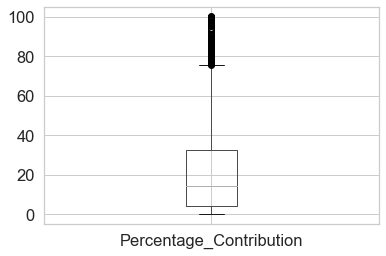

In [36]:
overall_sales_data_df.boxplot(column='Percentage_Contribution', return_type='axes')

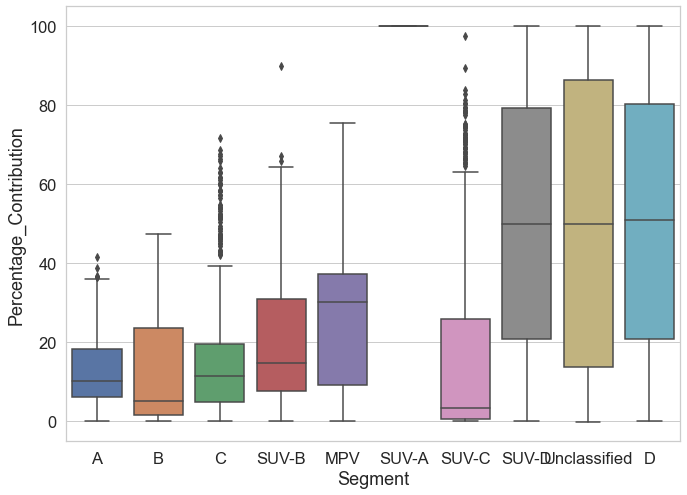

In [37]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x="Segment", y="Percentage_Contribution", data=overall_sales_data_df);

In [38]:
overall_sales_data_df.Segment = overall_sales_data_df.Segment.str.replace(r'\bA\b', 'Car A')
overall_sales_data_df.Segment = overall_sales_data_df.Segment.str.replace(r'\bB\b', 'Car B')
overall_sales_data_df.Segment = overall_sales_data_df.Segment.str.replace(r'\bC\b', 'Car C')
overall_sales_data_df.Segment = overall_sales_data_df.Segment.str.replace(r'\bD\b', 'Car D')

/var/folders/s0/w17scwd1277ff63dz232pg940000gp/T/ipykernel_43060/3798369130.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  overall_sales_data_df.Segment = overall_sales_data_df.Segment.str.replace(r'\bA\b', 'Car A')
/var/folders/s0/w17scwd1277ff63dz232pg940000gp/T/ipykernel_43060/3798369130.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  overall_sales_data_df.Segment = overall_sales_data_df.Segment.str.replace(r'\bB\b', 'Car B')
/var/folders/s0/w17scwd1277ff63dz232pg940000gp/T/ipykernel_43060/3798369130.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  overall_sales_data_df.Segment = overall_sales_data_df.Segment.str.replace(r'\bC\b', 'Car C')
/var/folders/s0/w17scwd1277ff63dz232pg940000gp/T/ipykernel_43060/3798369130.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  overall_s

In [39]:
overall_sales_data_df.Segment.unique()

array(['Car A', 'Car B', 'Car C', 'SUV-Car B', 'MPV', 'SUV-Car A',
       'SUV-Car C', 'SUV-Car D', 'Unclassified', 'Car D'], dtype=object)

### Step A.3: Get the features & price data

In [40]:
features_df = pd.read_csv('./features-data/cars_ds_final.csv')

In [41]:
# sample data preview
features_df.head(5)

,Unnamed: 0,Make,Model,Variant,Ex-Showroom_Price,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,...,Leather_Wrapped_Steering,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range
0,0,Tata,Nano Genx,Xt,"Rs. 2,92,667",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Tata,Nano Genx,Xe,"Rs. 2,36,447",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Tata,Nano Genx,Emax Xm,"Rs. 2,96,661",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Tata,Nano Genx,Xta,"Rs. 3,34,768",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Tata,Nano Genx,Xm,"Rs. 2,72,223",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#shape of the featues data
features_df.shape

(1276, 141)

In [43]:
#information of the car features data
features_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Data columns (total 141 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    Unnamed: 0                                 int64  
 1    Make                                       object 
 2    Model                                      object 
 3    Variant                                    object 
 4    Ex-Showroom_Price                          object 
 5    Displacement                               object 
 6    Cylinders                                  float64
 7    Valves_Per_Cylinder                        float64
 8    Drivetrain                                 object 
 9    Cylinder_Configuration                     object 
 10   Emission_Norm                              object 
 11   Engine_Location                            object 
 12   Fuel_System                                object 
 13   Fuel_Tank_Capacity             

In [44]:
# All the columns of Car Featues
features_df.columns.tolist()

['Unnamed: 0',
 'Make',
 'Model',
 'Variant',
 'Ex-Showroom_Price',
 'Displacement',
 'Cylinders',
 'Valves_Per_Cylinder',
 'Drivetrain',
 'Cylinder_Configuration',
 'Emission_Norm',
 'Engine_Location',
 'Fuel_System',
 'Fuel_Tank_Capacity',
 'Fuel_Type',
 'Height',
 'Length',
 'Width',
 'Body_Type',
 'Doors',
 'City_Mileage',
 'Highway_Mileage',
 'ARAI_Certified_Mileage',
 'ARAI_Certified_Mileage_for_CNG',
 'Kerb_Weight',
 'Gears',
 'Ground_Clearance',
 'Front_Brakes',
 'Rear_Brakes',
 'Front_Suspension',
 'Rear_Suspension',
 'Front_Track',
 'Rear_Track',
 'Front_Tyre_&_Rim',
 'Rear_Tyre_&_Rim',
 'Power_Steering',
 'Power_Windows',
 'Power_Seats',
 'Keyless_Entry',
 'Power',
 'Torque',
 'Odometer',
 'Speedometer',
 'Tachometer',
 'Tripmeter',
 'Seating_Capacity',
 'Seats_Material',
 'Type',
 'Wheelbase',
 'Wheels_Size',
 'Start_/_Stop_Button',
 '12v_Power_Outlet',
 'Audiosystem',
 'Aux-in_Compatibility',
 'Average_Fuel_Consumption',
 'Basic_Warranty',
 'Bluetooth',
 'Boot-lid_Opener',

In [45]:
# Description of the Features data
features_df.describe()

,Unnamed: 0,Cylinders,Valves_Per_Cylinder,Doors,Seating_Capacity,Number_of_Airbags,USB_Ports
count,1276.000000,1210.000000,1174.000000,1272.000000,1270.000000,1141.000000,29.000000
mean,637.500000,4.380992,3.977853,4.550314,5.270079,3.787029,1.793103
std,368.493781,1.660957,0.833763,0.747816,1.145231,2.522399,0.773642
min,0.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000
25%,318.750000,4.000000,4.000000,4.000000,5.000000,2.000000,1.000000
50%,637.500000,4.000000,4.000000,5.000000,5.000000,2.000000,2.000000
75%,956.250000,4.000000,4.000000,5.000000,5.000000,6.000000,2.000000
max,1275.000000,16.000000,16.000000,5.000000,16.000000,14.000000,3.000000


# Step B: Data Cleaning

### Step B.1: Cleaning Features + Price Data (At Make, Model and Varient Level)

In [46]:
# Dropping the Unamed columns as it is simply as index

features_df = features_df.drop('Unnamed: 0',axis=1)

In [47]:
# Dropping City_Mileage, Highway_Mileage and ARAI_Certified_Mileage_for_CNG as we are keeping ARAI_Certified_Mileage
features_df = features_df.drop(['City_Mileage','Highway_Mileage','ARAI_Certified_Mileage_for_CNG','Average_Fuel_Consumption'],axis=1)

In [48]:
# Dropping other specs
features_df = features_df.drop(['Tripmeter',"Other_Specs","Other_specs"],axis=1)

In [49]:
# Correcting minor issues in the csv files to get the current datatype
features_df['Ex-Showroom_Price'] = features_df['Ex-Showroom_Price'].str.replace('Rs. ','')
features_df['Ex-Showroom_Price'] = features_df['Ex-Showroom_Price'].str.replace(',','')
features_df['Ex-Showroom_Price'] = features_df['Ex-Showroom_Price'].astype(int)
features_df = features_df[~features_df.ARAI_Certified_Mileage.isnull()]
features_df = features_df[~features_df.Make.isnull()]
features_df = features_df[~features_df.Width.isnull()]
features_df = features_df[~features_df.Cylinders.isnull()]
features_df = features_df[~features_df.Wheelbase.isnull()]
features_df = features_df[~features_df['Fuel_Tank_Capacity'].isnull()]
features_df = features_df[~features_df['Seating_Capacity'].isnull()]
features_df = features_df[~features_df['Torque'].isnull()]
features_df['Height'] = features_df['Height'].str.replace(' mm','').astype(float)
features_df['Length'] = features_df['Length'].str.replace(' mm','').astype(float)
features_df['Width'] = features_df['Width'].str.replace(' mm','').astype(float)
features_df['Wheelbase'] = features_df['Wheelbase'].str.replace(' mm','').astype(float)
features_df['Fuel_Tank_Capacity'] = features_df['Fuel_Tank_Capacity'].str.replace(' litres','').astype(float)
features_df['Displacement'] = features_df['Displacement'].str.replace(' cc','')
features_df.loc[features_df.ARAI_Certified_Mileage == '9.8-10.0 km/litre','ARAI_Certified_Mileage'] = '10'
features_df.loc[features_df.ARAI_Certified_Mileage == '10kmpl km/litre','ARAI_Certified_Mileage'] = '10'
features_df['ARAI_Certified_Mileage'] = features_df['ARAI_Certified_Mileage'].str.replace(' km/litre','').astype(float)
features_df.Number_of_Airbags.fillna(0,inplace= True)
features_df['price'] = features_df['Ex-Showroom_Price']
features_df.drop(columns='Ex-Showroom_Price', inplace= True)
features_df.price = features_df.price.astype(int)
HP = features_df.Power.str.extract(r'(\d{1,4}).*').astype(int) * 0.98632
HP = HP.apply(lambda x: round(x,2))
TQ = features_df.Torque.str.extract(r'(\d{1,4}).*').astype(int)
TQ = TQ.apply(lambda x: round(x,2))
features_df.Torque = TQ
features_df.Power = HP
features_df.Doors = features_df.Doors.astype(int)
features_df.Seating_Capacity = features_df.Seating_Capacity.astype(int)
features_df.Number_of_Airbags = features_df.Number_of_Airbags.astype(int)
features_df.Displacement = features_df.Displacement.astype(int)
features_df.Cylinders = features_df.Cylinders.astype(int)
features_df["Kerb_Weight"] = features_df["Kerb_Weight"].str.replace(' kg','')
features_df["Kerb_Weight"] = features_df["Kerb_Weight"].apply(pd.to_numeric, errors='coerce').fillna(0)
features_df["Ground_Clearance"] = features_df["Ground_Clearance"].str.replace(' mm','')
features_df["Ground_Clearance"] = features_df["Ground_Clearance"].apply(pd.to_numeric, errors='coerce').fillna(0)
features_df["Front_Track"] = features_df["Front_Track"].str.replace(' mm','')
features_df["Front_Track"] = features_df["Front_Track"].apply(pd.to_numeric, errors='coerce').fillna(0)
features_df["Rear_Track"] = features_df["Rear_Track"].str.replace(' mm','')
features_df["Rear_Track"] = features_df["Rear_Track"].apply(pd.to_numeric, errors='coerce').fillna(0)
features_df["Minimum_Turning_Radius"] = features_df["Minimum_Turning_Radius"].str.replace(' meter','')
features_df["Minimum_Turning_Radius"] = features_df["Minimum_Turning_Radius"].apply(pd.to_numeric, errors='coerce').fillna(0)
features_df["Gross_Vehicle_Weight"] = features_df["Gross_Vehicle_Weight"].str.replace(' kg','')
features_df["Gross_Vehicle_Weight"] = features_df["Gross_Vehicle_Weight"].apply(pd.to_numeric, errors='coerce').fillna(0)


/var/folders/s0/w17scwd1277ff63dz232pg940000gp/T/ipykernel_43060/1642787549.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  features_df['Ex-Showroom_Price'] = features_df['Ex-Showroom_Price'].str.replace('Rs. ','')


In [50]:
# Add Price variation at variant level for Make-Model to the features data using Normal Distribution

features_df["price_normalized_x"] = features_df.groupby(["Make","Model"])["price"].transform(lambda x: abs(x - x.mean()) / x.std())
temp_group = features_df.groupby(["Make","Model"], sort=False)["price_normalized_x"].sum().reset_index(name ='price_normalized_x_model_level_sum')
features_df = features_df.merge(temp_group, on=["Make","Model"])

In [51]:
# Check Price variant at Make-Model level
features_df.loc[features_df["Model"]=="Amaze"]

,Make,Model,Variant,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,Emission_Norm,Engine_Location,...,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range,price,price_normalized_x,price_normalized_x_model_level_sum
360,Honda,Amaze,S Cvt Petrol,1199,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,763000,0.610800,15.961898
361,Honda,Amaze,E Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,705000,1.195781,15.961898
362,Honda,Amaze,E Mt Petrol,1199,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,593000,2.325398,15.961898
363,Honda,Amaze,S Cvt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,865000,0.417958,15.961898
364,Honda,Amaze,V Cvt Petrol,1199,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823000,0.005648,15.961898
365,Honda,Amaze,V Cvt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,925000,1.023111,15.961898
366,Honda,Amaze,S Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,785000,0.388911,15.961898
367,Honda,Amaze,Vx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,NaN,Yes,NaN,NaN,NaN,NaN,NaN,893000,0.700363,15.961898
368,Honda,Amaze,V Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,845000,0.216241,15.961898
369,Honda,Amaze,Vx Mt Petrol,1199,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,NaN,Yes,NaN,NaN,NaN,NaN,NaN,781000,0.429255,15.961898


In [52]:
# Get info to check columns datatypes
features_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 986
Data columns (total 135 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    Make                                       object 
 1    Model                                      object 
 2    Variant                                    object 
 3    Displacement                               int64  
 4    Cylinders                                  int64  
 5    Valves_Per_Cylinder                        float64
 6    Drivetrain                                 object 
 7    Cylinder_Configuration                     object 
 8    Emission_Norm                              object 
 9    Engine_Location                            object 
 10   Fuel_System                                object 
 11   Fuel_Tank_Capacity                         float64
 12   Fuel_Type                                  object 
 13   Height                           

In [53]:
# Handle all NaN value - BIUFC stands for boolean, signed integer, 
# unsigned integer, floating-point, complex floating-point

features_df = features_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('No'))

In [54]:
features_df

,Make,Model,Variant,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,Emission_Norm,Engine_Location,...,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range,price,price_normalized_x,price_normalized_x_model_level_sum
0,Tata,Nano Genx,Xt,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,0.0,No,No,No,No,292667,0.065146,3.762247
1,Tata,Nano Genx,Xe,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,0.0,No,No,No,No,236447,1.409885,3.762247
2,Tata,Nano Genx,Xta,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,0.0,No,No,No,No,334768,1.169740,3.762247
3,Tata,Nano Genx,Xm,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,0.0,No,No,No,No,272223,0.471239,3.762247
4,Tata,Nano Genx,Xma,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,0.0,No,No,No,No,314815,0.646238,3.762247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,Honda,City,Vx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS IV,"Front, Transverse",...,No,Yes,0.0,No,No,No,No,1302000,0.557725,8.005534
983,Honda,City,Zx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS IV,"Front, Transverse",...,No,Yes,0.0,No,No,No,No,1421000,1.374981,8.005534
984,Honda,City,Zx Cvt Petrol,1497,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,No,Yes,0.0,No,No,No,No,1431000,1.443658,8.005534
985,Honda,City,V Cvt Petrol,1497,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,No,Yes,0.0,No,No,No,No,1201000,0.135912,8.005534


In [55]:
# Final info for the Features + Price data
features_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 986
Data columns (total 135 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    Make                                       object 
 1    Model                                      object 
 2    Variant                                    object 
 3    Displacement                               int64  
 4    Cylinders                                  int64  
 5    Valves_Per_Cylinder                        float64
 6    Drivetrain                                 object 
 7    Cylinder_Configuration                     object 
 8    Emission_Norm                              object 
 9    Engine_Location                            object 
 10   Fuel_System                                object 
 11   Fuel_Tank_Capacity                         float64
 12   Fuel_Type                                  object 
 13   Height                           

## Step B.2 Cleaning the Sales Data

In [56]:
## Get the info of the sales data
overall_sales_data_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2685 entries, 0 to 3095
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Group                    2685 non-null   object        
 1   Maker/Brand              2685 non-null   object        
 2   Type                     2685 non-null   object        
 3   Segment                  2685 non-null   object        
 4   Model                    2685 non-null   object        
 5   Month                    2685 non-null   datetime64[ns]
 6   Sales                    2685 non-null   float64       
 7   Monthly_Segment_Sales    2685 non-null   float64       
 8   Percentage_Contribution  2641 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 209.8+ KB


In [57]:
# Rename column containing slash (/) - We prefeer columns to have underscore
overall_sales_data_df["Make"] = overall_sales_data_df["Maker/Brand"]
overall_sales_data_df.drop(columns='Maker/Brand', inplace= True)
overall_sales_data_df.shape

(2685, 9)

In [58]:
# Dropping Unclassified Segment Records
overall_sales_data_df = overall_sales_data_df[~(overall_sales_data_df.Segment == "Unclassified")]
overall_sales_data_df.shape

(2559, 9)

In [71]:
overall_sales_data_df[overall_sales_data_df.Segment == "MPV"].Model.unique()

array(['Eeco', 'Ertiga', 'Innova', 'Go+'], dtype=object)

## Step B.3 : Cleaning Features Data Outliers 

In [28]:
# Checking for outliers
plt.figure(figsize=(40,80), dpi=200)
index = 1
for column in features_df.columns.values:
    if features_df[column].dtype.kind in 'biufc':
        plt.subplot(10,3,index)
        index +=1
        sns.boxplot(x = column, data = features_df)
    

In [29]:
# checking for outliers using the Z-score

numeric_columns = []
for column in features_df.columns.values:
    if features_df[column].dtype.kind in 'biufc':
        numeric_columns.append(column)
z = np.abs(stats.zscore(features_df[numeric_columns]))

# Decide the THRESHOLD on the basis of count of the dropping records
THRESHOLD = 4
old_records = features_df.shape
dropping_records = z[(z > THRESHOLD).any(1)].shape

print(f"Dropping {dropping_records[0]} from {old_records[0]} entries")
print(f"Making total entries as {old_records[0]-dropping_records[0]}")

Dropping 64 from 987 entries
Making total entries as 923


In [30]:
# Drop the records
features_df_outliers_removed = features_df[(z<THRESHOLD).all(axis=1)]
features_df_outliers_removed.shape

(923, 135)

In [31]:
features_df_outliers_removed


,Make,Model,Variant,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,Emission_Norm,Engine_Location,...,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range,price,price_normalized_x,price_normalized_x_model_level_sum
0,Tata,Nano Genx,Xt,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,0.0,No,No,No,No,292667,0.065146,3.762247
1,Tata,Nano Genx,Xe,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,0.0,No,No,No,No,236447,1.409885,3.762247
2,Tata,Nano Genx,Xta,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,0.0,No,No,No,No,334768,1.169740,3.762247
3,Tata,Nano Genx,Xm,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,0.0,No,No,No,No,272223,0.471239,3.762247
4,Tata,Nano Genx,Xma,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,0.0,No,No,No,No,314815,0.646238,3.762247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,Honda,City,Vx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS IV,"Front, Transverse",...,No,Yes,0.0,No,No,No,No,1302000,0.557725,8.005534
983,Honda,City,Zx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS IV,"Front, Transverse",...,No,Yes,0.0,No,No,No,No,1421000,1.374981,8.005534
984,Honda,City,Zx Cvt Petrol,1497,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,No,Yes,0.0,No,No,No,No,1431000,1.443658,8.005534
985,Honda,City,V Cvt Petrol,1497,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,No,Yes,0.0,No,No,No,No,1201000,0.135912,8.005534


# Step C: Data Preparation

Merge both the sales data and features + price data together

## Step C.1 : Merge the sales and (price+features) data
Important points:
1. Sales data is at Make-Model-Month level
2. Price data is at Make-Model-Varient level

In [32]:
# Inner merge to keep the common data only
complete_data_df = overall_sales_data_df.merge(features_df,how='inner',\
                            left_on=['Make','Model'],\
                            right_on=['Make',"Model"])


In [33]:
# Get the info
complete_data_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6381 entries, 0 to 6380
Data columns (total 142 columns):
 #    Column                                     Dtype         
---   ------                                     -----         
 0    Group                                      object        
 1    Type_x                                     object        
 2    Segment                                    object        
 3    Model                                      object        
 4    Month                                      datetime64[ns]
 5    Sales                                      float64       
 6    Monthly_Segment_Sales                      float64       
 7    Percentage_Contribution                    float64       
 8    Make                                       object        
 9    Variant                                    object        
 10   Displacement                               int64         
 11   Cylinders                                  int64      

In [34]:
# Get the shape
complete_data_df.shape

(6381, 142)

In [35]:
# First 5 rows
complete_data_df.head(5)

,Group,Type_x,Segment,Model,Month,Sales,Monthly_Segment_Sales,Percentage_Contribution,Make,Variant,...,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range,price,price_normalized_x,price_normalized_x_model_level_sum
0,Honda,Cars,A,Amaze,2022-01-01,5295.0,64417.0,8.21988,Honda,S Cvt Petrol,...,No,No,0.0,No,No,No,No,763000,0.610800,15.961898
1,Honda,Cars,A,Amaze,2022-01-01,5295.0,64417.0,8.21988,Honda,E Mt Diesel,...,No,No,0.0,No,No,No,No,705000,1.195781,15.961898
2,Honda,Cars,A,Amaze,2022-01-01,5295.0,64417.0,8.21988,Honda,E Mt Petrol,...,No,No,0.0,No,No,No,No,593000,2.325398,15.961898
3,Honda,Cars,A,Amaze,2022-01-01,5295.0,64417.0,8.21988,Honda,S Cvt Diesel,...,No,No,0.0,No,No,No,No,865000,0.417958,15.961898
4,Honda,Cars,A,Amaze,2022-01-01,5295.0,64417.0,8.21988,Honda,V Cvt Petrol,...,No,No,0.0,No,No,No,No,823000,0.005648,15.961898


In [36]:
# Get the Models which are covered after the merge
complete_data_df["Model"].unique()


array(['Amaze', 'City', 'Kodiaq', 'Tiago', 'Tigor', 'Nexon', 'Xcent',
       'Camry', 'Fortuner', 'Kwid', 'Go'], dtype=object)

In [37]:
complete_data_df['Month'] = pd.to_datetime(complete_data_df['Month'], format='%Y-%m-%d')

## Step C.2 Spread Model level sales data at (it's) Varient level based on the price

In [38]:
# Using the normal distribution of the price, we have extended monthly sales at model level to the varient level

complete_data_df.loc[(complete_data_df["Month"]=="2022-01-01") & (complete_data_df["Model"]=="Amaze")]
complete_data_df["Varient_Level_Sales"] = np.round(complete_data_df["Sales"]*complete_data_df.price_normalized_x/complete_data_df.price_normalized_x_model_level_sum)
complete_data_df.drop(["price_normalized_x","price_normalized_x_model_level_sum"], axis=1, inplace=True)



In [39]:
complete_data_df.head(5)

,Group,Type_x,Segment,Model,Month,Sales,Monthly_Segment_Sales,Percentage_Contribution,Make,Variant,...,Engine_Type,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range,price,Varient_Level_Sales
0,Honda,Cars,A,Amaze,2022-01-01,5295.0,64417.0,8.21988,Honda,S Cvt Petrol,...,No,No,No,0.0,No,No,No,No,763000,203.0
1,Honda,Cars,A,Amaze,2022-01-01,5295.0,64417.0,8.21988,Honda,E Mt Diesel,...,No,No,No,0.0,No,No,No,No,705000,397.0
2,Honda,Cars,A,Amaze,2022-01-01,5295.0,64417.0,8.21988,Honda,E Mt Petrol,...,No,No,No,0.0,No,No,No,No,593000,771.0
3,Honda,Cars,A,Amaze,2022-01-01,5295.0,64417.0,8.21988,Honda,S Cvt Diesel,...,No,No,No,0.0,No,No,No,No,865000,139.0
4,Honda,Cars,A,Amaze,2022-01-01,5295.0,64417.0,8.21988,Honda,V Cvt Petrol,...,No,No,No,0.0,No,No,No,No,823000,2.0


# Step D: Data Visualization

# Step E: Cluster Creation

## Step E.1: Converting the string data into numeric 

In [40]:
features_df_outliers_removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 986
Columns: 135 entries, Make to price_normalized_x_model_level_sum
dtypes: float64(17), int64(7), object(111)
memory usage: 980.7+ KB


In [41]:
X = features_df_outliers_removed.drop(['Make','Model','Variant'],axis =1)  
Y = features_df_outliers_removed[['Make','Model','Variant']]

In [42]:
## Standardize the object categorical data so that it can be used
from sklearn.preprocessing import LabelEncoder
# Creating a instance of label Encoder.
le = LabelEncoder()
X_copy = X
for column in X_copy.columns.values:
    if not (X_copy[column].dtype.kind in 'biufc'):
        label = le.fit_transform(X[column])
        X.drop(column, axis=1, inplace=True)
        X[column]=label     

## Step E.2 Principal Component Analysis 

In [43]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 986
Data columns (total 132 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    Displacement                               int64  
 1    Cylinders                                  int64  
 2    Valves_Per_Cylinder                        float64
 3    Fuel_Tank_Capacity                         float64
 4    Height                                     float64
 5    Length                                     float64
 6    Width                                      float64
 7    Doors                                      int64  
 8    ARAI_Certified_Mileage                     float64
 9    Kerb_Weight                                float64
 10   Ground_Clearance                           float64
 11   Front_Track                                float64
 12   Rear_Track                                 float64
 13   Power                            

In [44]:
## Shapes of X & Y. Y contains the Make Model Varient which we are keeping separately
X.shape
Y.shape

(923, 3)

In [45]:
X.head(2)

,Displacement,Cylinders,Valves_Per_Cylinder,Fuel_Tank_Capacity,Height,Length,Width,Doors,ARAI_Certified_Mileage,Kerb_Weight,...,Paddle_Shifters,Leather_Wrapped_Steering,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range
0,624,2,2.0,24.0,1652.0,3164.0,1750.0,5,23.6,660.0,...,0,0,0,2,0,0,0,0,0,0
1,624,2,2.0,24.0,1652.0,3164.0,1750.0,5,23.6,725.0,...,0,0,0,2,0,0,0,0,0,0


In [46]:
Y.head(2)

,Make,Model,Variant
0,Tata,Nano Genx,Xt
1,Tata,Nano Genx,Xe


In [47]:
# Standardization of the dataset before performing PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [48]:
# Dataframe of Standardized Scaled version of X
X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled_df.head(5)

,Displacement,Cylinders,Valves_Per_Cylinder,Fuel_Tank_Capacity,Height,Length,Width,Doors,ARAI_Certified_Mileage,Kerb_Weight,...,Paddle_Shifters,Leather_Wrapped_Steering,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range
0,-1.55814,-2.31435,-2.019523,-1.834955,0.41098,-2.596421,-0.151532,0.595921,1.113346,-0.469317,...,-0.424626,-0.827228,-0.704236,-0.029786,-0.59946,-0.738961,-0.128529,-0.170251,0.0,0.0
1,-1.55814,-2.31435,-2.019523,-1.834955,0.41098,-2.596421,-0.151532,0.595921,1.113346,-0.371394,...,-0.424626,-0.827228,-0.704236,-0.029786,-0.59946,-0.738961,-0.128529,-0.170251,0.0,0.0
2,-1.55814,-2.31435,-2.019523,-1.834955,0.41098,-2.596421,-0.151532,0.595921,0.710429,-0.371394,...,-0.424626,-0.827228,-0.704236,-0.029786,-0.59946,-0.738961,-0.128529,-0.170251,0.0,0.0
3,-1.55814,-2.31435,-2.019523,-1.834955,0.41098,-2.596421,-0.151532,0.595921,1.113346,-0.371394,...,-0.424626,-0.827228,-0.704236,-0.029786,-0.59946,-0.738961,-0.128529,-0.170251,0.0,0.0
4,-1.55814,-2.31435,-2.019523,-1.834955,0.41098,-2.596421,-0.151532,0.595921,0.710429,-0.393992,...,-0.424626,-0.827228,-0.704236,-0.029786,-0.59946,-0.738961,-0.128529,-0.170251,0.0,0.0


<AxesSubplot:>

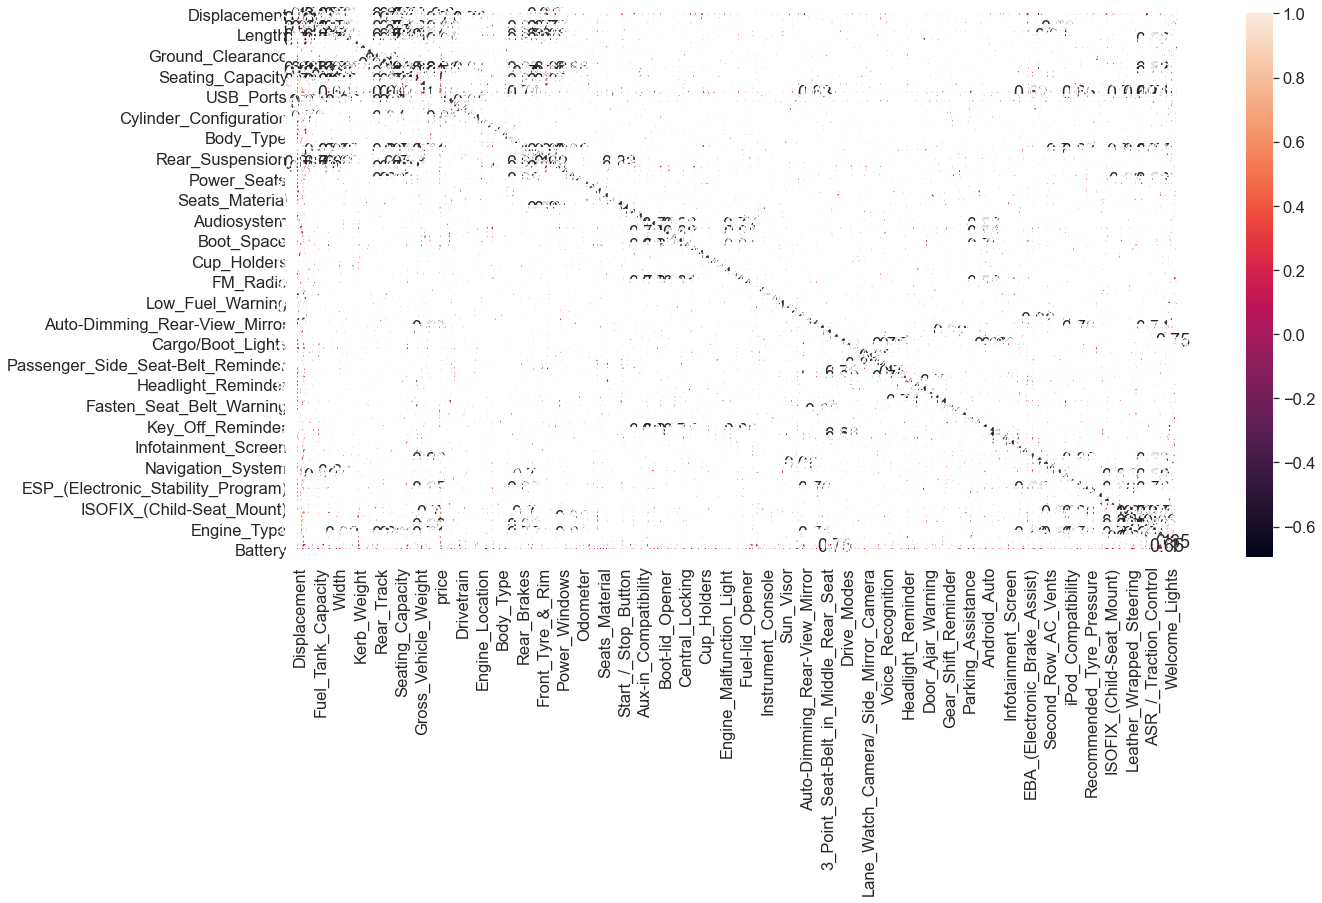

In [49]:
# The correlation matrix 
plt.figure(figsize = (20,10))       
sns.heatmap(X_scaled_df.corr(),annot = True)

In [50]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(X_scaled)
pca.components_[0]
pca.explained_variance_ratio_

array([1.99545103e-01, 6.67411317e-02, 5.28626140e-02, 3.48995043e-02,
       3.23392687e-02, 2.58957701e-02, 2.20230275e-02, 2.18971361e-02,
       1.95132146e-02, 1.86046107e-02, 1.68043577e-02, 1.55682617e-02,
       1.52291834e-02, 1.39424689e-02, 1.30735351e-02, 1.24477737e-02,
       1.20939145e-02, 1.17201778e-02, 1.13142393e-02, 1.10827879e-02,
       1.09451935e-02, 1.04792782e-02, 9.69719845e-03, 9.64994571e-03,
       9.57459808e-03, 9.22026031e-03, 9.06012037e-03, 8.68015565e-03,
       8.52123600e-03, 8.19717885e-03, 7.87753765e-03, 7.79739870e-03,
       7.52072288e-03, 7.35680766e-03, 7.13359644e-03, 7.03543527e-03,
       6.92615326e-03, 6.78577444e-03, 6.47083946e-03, 6.25477911e-03,
       6.11486444e-03, 6.01082891e-03, 5.85325557e-03, 5.71618361e-03,
       5.62096258e-03, 5.41600237e-03, 5.29784021e-03, 5.26490380e-03,
       4.99641380e-03, 4.83048887e-03, 4.59419300e-03, 4.53610672e-03,
       4.40080045e-03, 4.30412219e-03, 4.16106643e-03, 4.08592847e-03,
      

In [51]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu

array([0.1995451 , 0.26628623, 0.31914885, 0.35404835, 0.38638762,
       0.41228339, 0.43430642, 0.45620356, 0.47571677, 0.49432138,
       0.51112574, 0.526694  , 0.54192318, 0.55586565, 0.56893919,
       0.58138696, 0.59348088, 0.60520105, 0.61651529, 0.62759808,
       0.63854327, 0.64902255, 0.65871975, 0.6683697 , 0.67794429,
       0.68716455, 0.69622468, 0.70490483, 0.71342607, 0.72162325,
       0.72950078, 0.73729818, 0.74481891, 0.75217571, 0.75930931,
       0.76634474, 0.7732709 , 0.78005667, 0.78652751, 0.79278229,
       0.79889716, 0.80490798, 0.81076124, 0.81647742, 0.82209839,
       0.82751439, 0.83281223, 0.83807713, 0.84307355, 0.84790403,
       0.85249823, 0.85703433, 0.86143514, 0.86573926, 0.86990032,
       0.87398625, 0.87794637, 0.88185431, 0.88569642, 0.88945951,
       0.89312816, 0.89671108, 0.90007303, 0.90339125, 0.90660983,
       0.90978374, 0.91290877, 0.91594382, 0.91891497, 0.92182976,
       0.92469618, 0.92752493, 0.93022899, 0.93289357, 0.93546

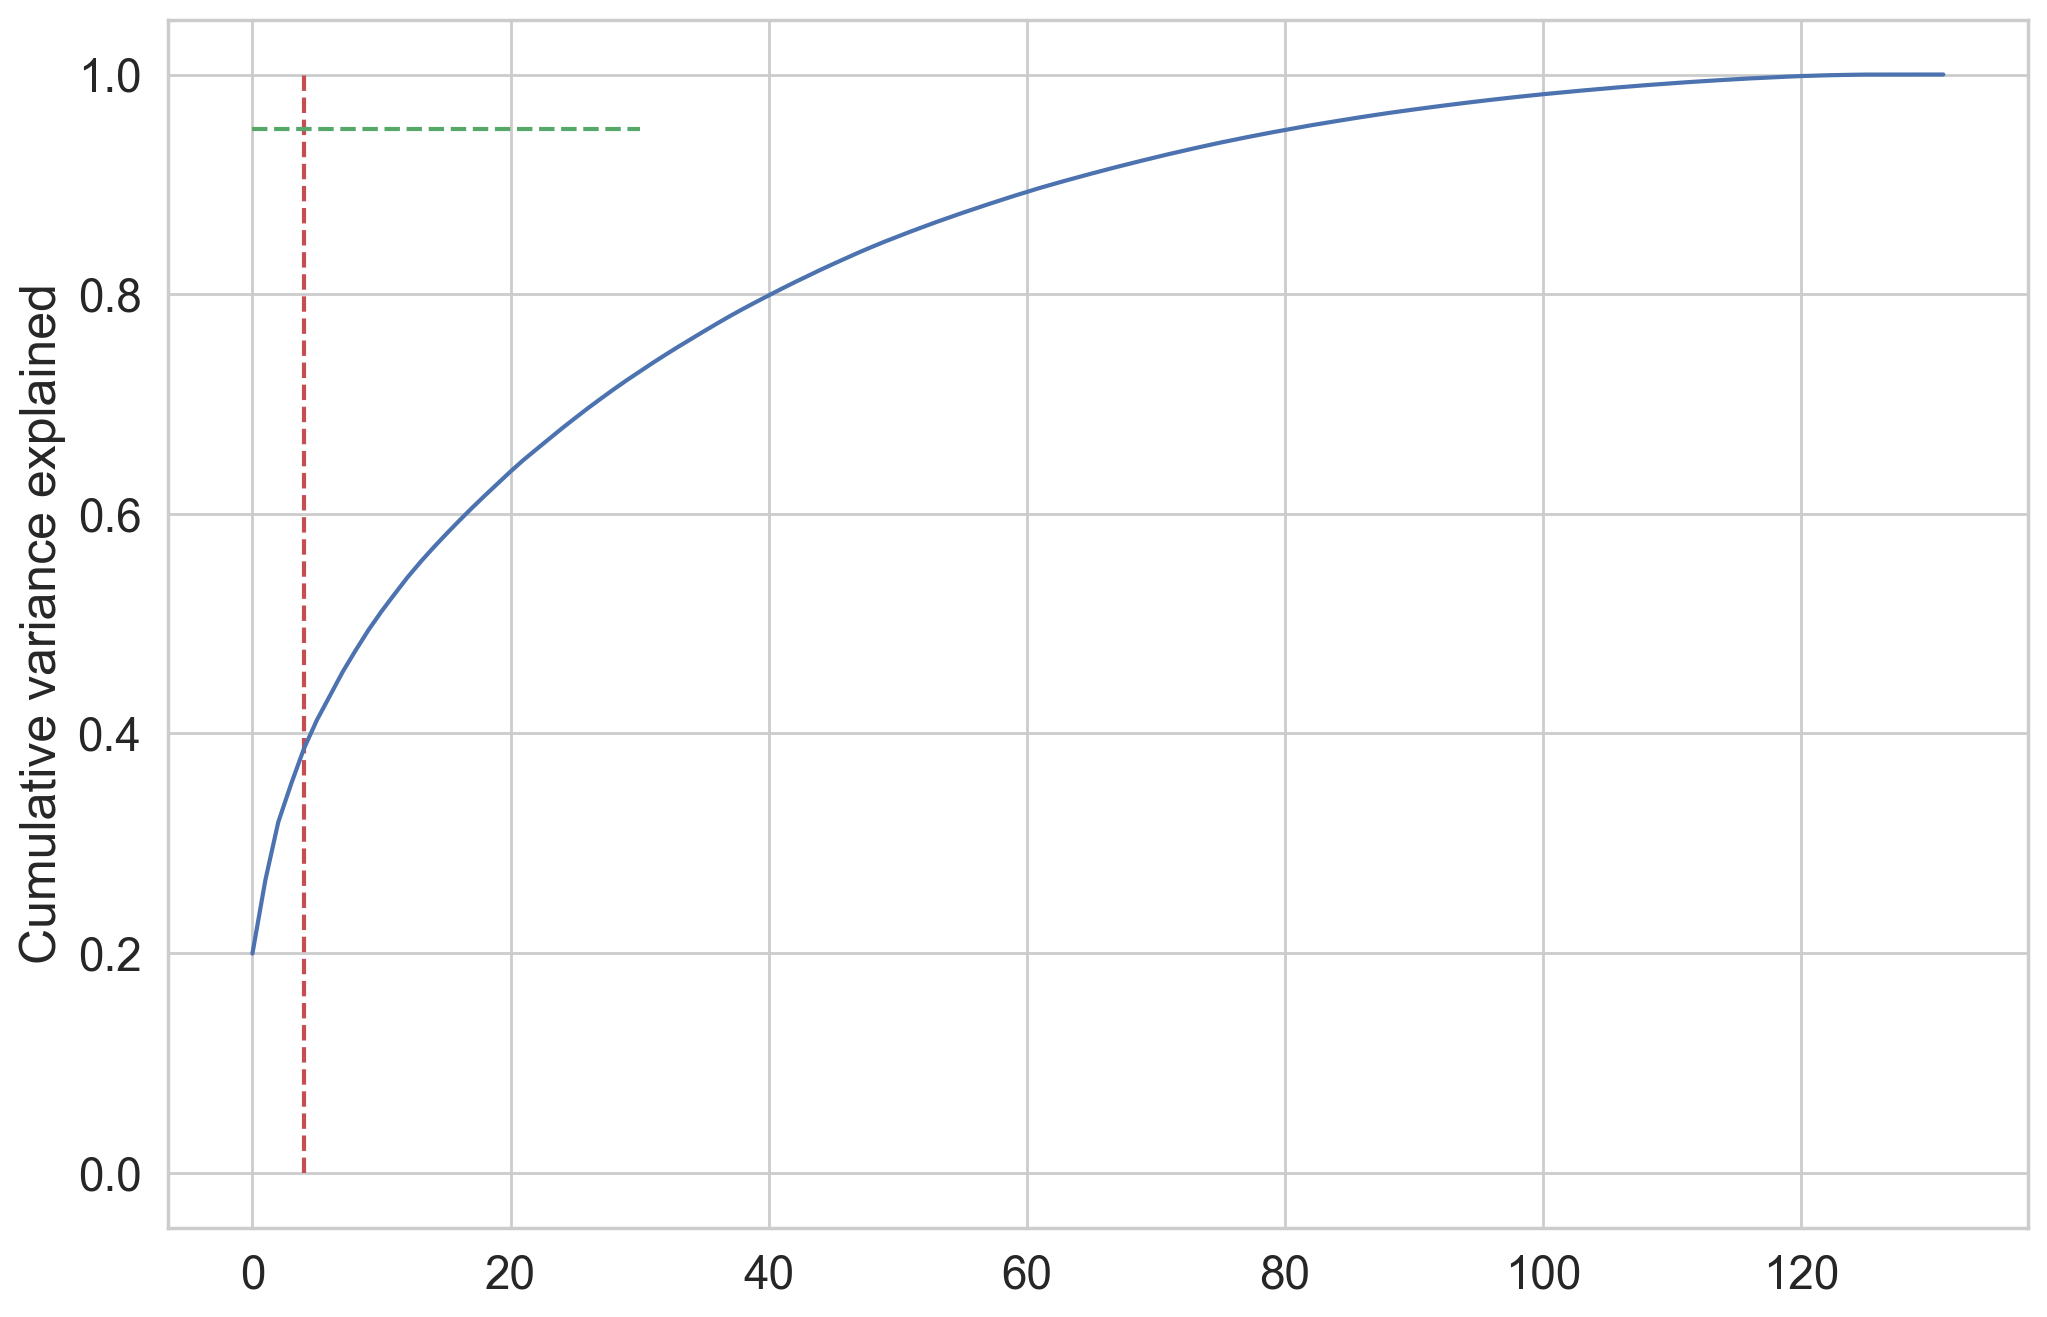

In [52]:
fig = plt.figure(figsize=[12,8],dpi=200)
plt.vlines(x=4, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [53]:
from sklearn.decomposition import IncrementalPCA

In [54]:
pca_final = IncrementalPCA(n_components=3)

In [55]:
X_pca_final = pca_final.fit_transform(X_scaled)

In [56]:
X_pca_final = pd.DataFrame(X_pca_final) 
X_pca_final.columns = ['P1', 'P2','P3'] 

In [57]:
corrmat = np.corrcoef(X_pca_final.transpose())

In [58]:
corrmat.shape

(3, 3)

<AxesSubplot:>

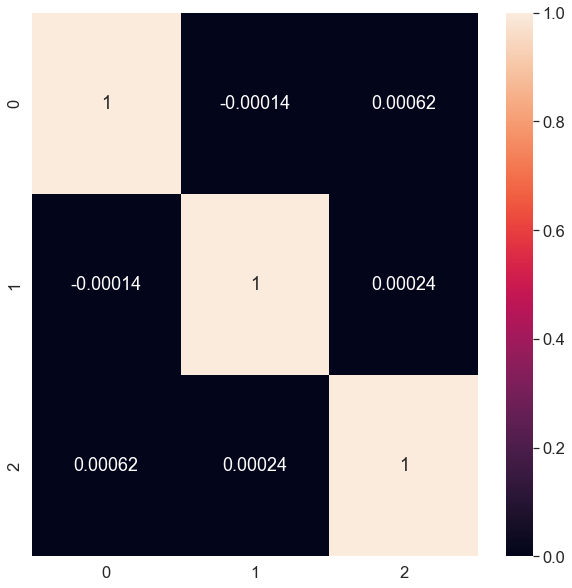

In [59]:
# Plotting the heatmap of the corr matrix
plt.figure(figsize=[10,10])
sns.heatmap(corrmat, annot=True)

In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [61]:
# k-means with some arbitrary k (number of clusters)
kmeans = KMeans(n_clusters=5, max_iter=1000)
kmeans.fit(X_pca_final)

KMeans(max_iter=1000, n_clusters=5)

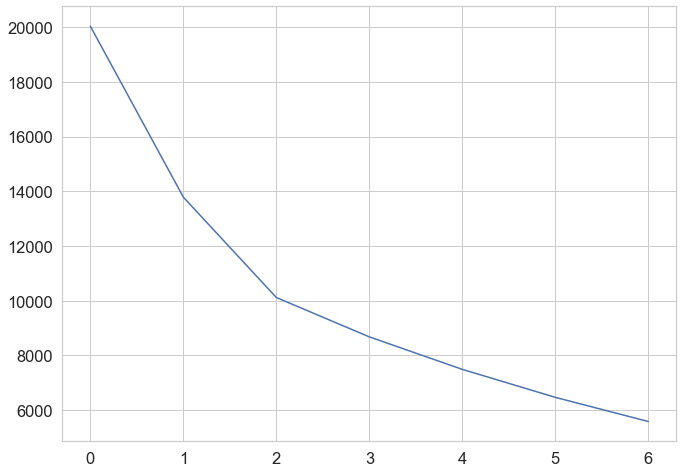

In [62]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_pca_final)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [63]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_pca_final)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_pca_final, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.48998778276692495
For n_clusters=3, the silhouette score is 0.4328236821268074
For n_clusters=4, the silhouette score is 0.4662187552756667
For n_clusters=5, the silhouette score is 0.44158456859161244
For n_clusters=6, the silhouette score is 0.43935762618987206
For n_clusters=7, the silhouette score is 0.3688924495293787
For n_clusters=8, the silhouette score is 0.36957571444399995


In [64]:
# final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=1000, random_state=42)
kmeans.fit(X_pca_final)

KMeans(max_iter=1000, n_clusters=4, random_state=42)

In [65]:
X_pca_final

,P1,P2,P3
0,-8.464983,-1.558573,1.733059
1,-10.173359,-4.275970,3.638527
2,-7.764741,-1.679785,1.912598
3,-9.794754,-3.713137,3.226453
4,-8.698886,-3.605649,3.191431
...,...,...,...
918,0.297802,2.462808,-1.025788
919,1.375526,2.963250,-1.400148
920,0.827447,3.132573,-0.741273
921,-0.447083,2.366221,-0.486117


/Users/vidhisingh/Work/ms_engage/dev/ms-engage-segmently/venv/lib/python3.8/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


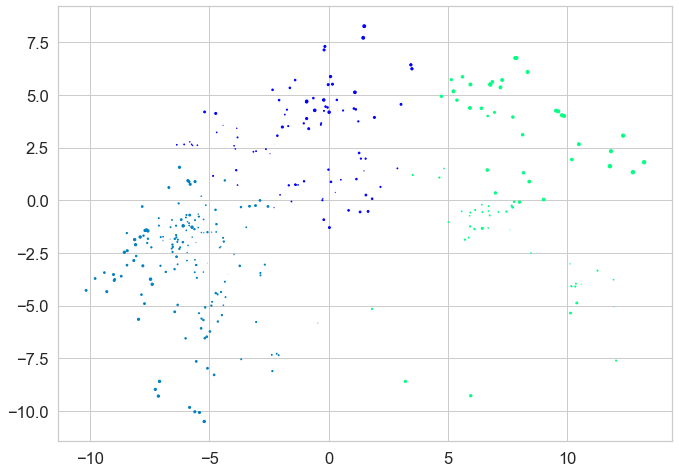

In [66]:
# Visualizing the clustering 
plt.scatter(X_pca_final['P1'], X_pca_final['P2'], X_pca_final['P3'],
           c = KMeans(n_clusters = 3).fit_predict(X_pca_final), cmap =plt.cm.winter) 
plt.show() 

In [67]:
features_df_outliers_removed['K-Means_Cluster_ID'] = kmeans.labels_
features_df_outliers_removed['P1'] = pd.Series(X_pca_final['P1'].values)
features_df_outliers_removed['P2'] = pd.Series(X_pca_final['P2'].values)
features_df_outliers_removed['P3'] = pd.Series(X_pca_final['P3'].values)

/var/folders/s0/w17scwd1277ff63dz232pg940000gp/T/ipykernel_1603/2618127639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df_outliers_removed['K-Means_Cluster_ID'] = kmeans.labels_
/var/folders/s0/w17scwd1277ff63dz232pg940000gp/T/ipykernel_1603/2618127639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df_outliers_removed['P1'] = pd.Series(X_pca_final['P1'].values)
/var/folders/s0/w17scwd1277ff63dz232pg940000gp/T/ipykernel_1603/2618127639.py:3: SettingWithCopyWarning: 
A value is 

In [68]:
features_df_outliers_removed

,Make,Model,Variant,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,Emission_Norm,Engine_Location,...,Welcome_Lights,Battery,Electric_Range,price,price_normalized_x,price_normalized_x_model_level_sum,K-Means_Cluster_ID,P1,P2,P3
0,Tata,Nano Genx,Xt,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,292667,0.065146,3.762247,0,-8.464983,-1.558573,1.733059
1,Tata,Nano Genx,Xe,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,236447,1.409885,3.762247,0,-10.173359,-4.275970,3.638527
2,Tata,Nano Genx,Xta,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,334768,1.169740,3.762247,0,-7.764741,-1.679785,1.912598
3,Tata,Nano Genx,Xm,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,272223,0.471239,3.762247,0,-9.794754,-3.713137,3.226453
4,Tata,Nano Genx,Xma,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,314815,0.646238,3.762247,0,-8.698886,-3.605649,3.191431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,Honda,City,Vx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS IV,"Front, Transverse",...,No,No,No,1302000,0.557725,8.005534,1,NaN,NaN,NaN
983,Honda,City,Zx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS IV,"Front, Transverse",...,No,No,No,1421000,1.374981,8.005534,1,NaN,NaN,NaN
984,Honda,City,Zx Cvt Petrol,1497,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,No,No,No,1431000,1.443658,8.005534,1,NaN,NaN,NaN
985,Honda,City,V Cvt Petrol,1497,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,No,No,No,1201000,0.135912,8.005534,1,NaN,NaN,NaN


<AxesSubplot:xlabel='K-Means_Cluster_ID', ylabel='price'>

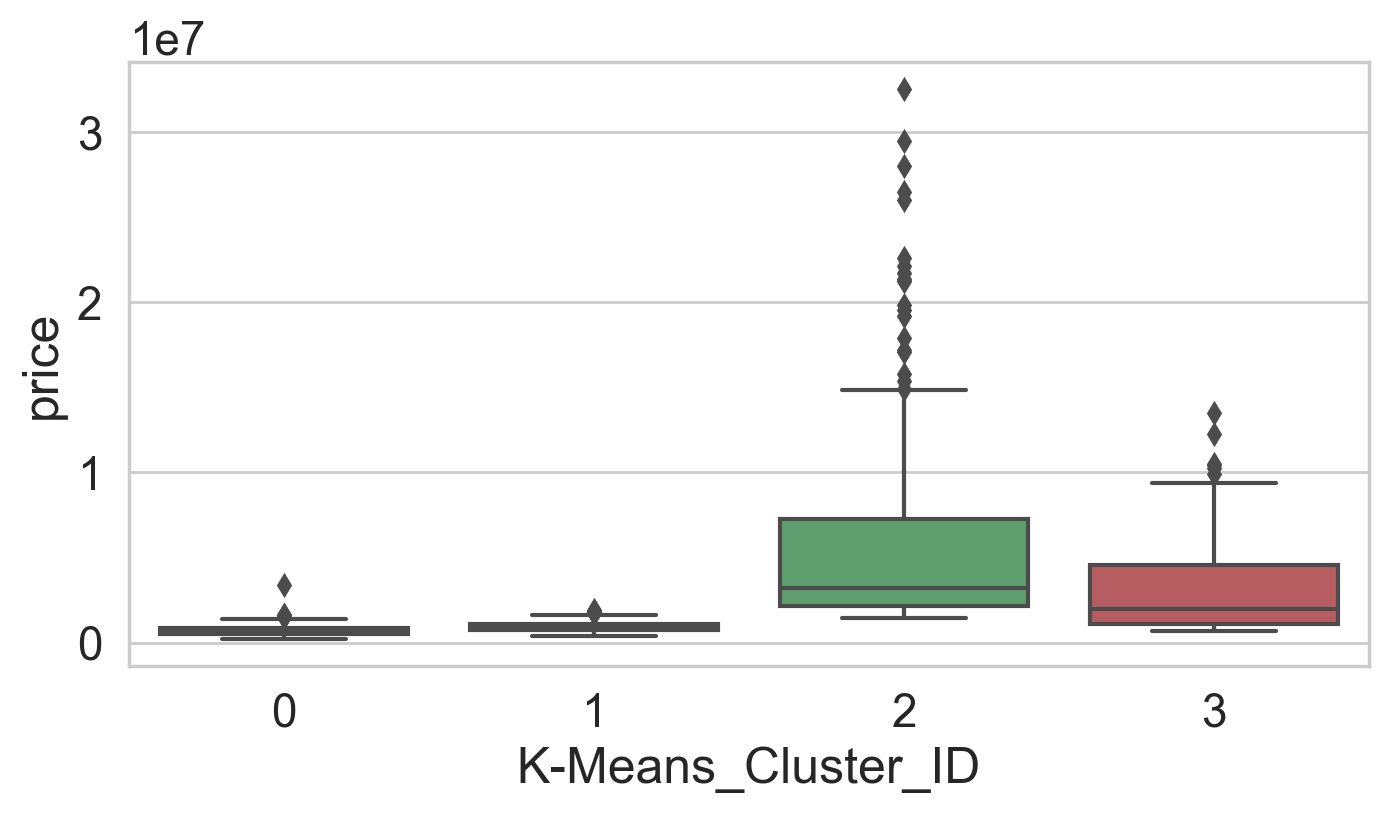

In [69]:
## Price wise cluster comparison
plt.figure(figsize=(8,4),dpi=200)
sns.boxplot(x='K-Means_Cluster_ID', y='price', data=features_df_outliers_removed)

# Step F: Multipolynomial Regression

In [70]:
# Get the shape
complete_data_df.shape

(6381, 141)

In [71]:
# Get the info
complete_data_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6381 entries, 0 to 6380
Data columns (total 141 columns):
 #    Column                                     Dtype         
---   ------                                     -----         
 0    Group                                      object        
 1    Type_x                                     object        
 2    Segment                                    object        
 3    Model                                      object        
 4    Month                                      datetime64[ns]
 5    Sales                                      float64       
 6    Monthly_Segment_Sales                      float64       
 7    Percentage_Contribution                    float64       
 8    Make                                       object        
 9    Variant                                    object        
 10   Displacement                               int64         
 11   Cylinders                                  int64      

In [72]:
# Splitting the Data into Training and Testing Sets
# We specify this so that the train and test data set always have the same rows, respectively
# We divide the df into 70/30 ratio
from sklearn.model_selection import train_test_split
np.random.seed(4)
df_train, df_test = train_test_split(complete_data_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [73]:
# Training data
df_train.shape

(4466, 141)

## Rescaling the Features
For Simple Linear Regression, scaling doesn't impact model. So it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. There are two common ways of rescaling:

Min-Max scaling
Standardisation (mean-0, sigma-1)
Here, we will use Standardisation Scaling.

In [85]:
X = df_train

In [86]:
## Standardize the object categorical data so that it can be used
from sklearn.preprocessing import LabelEncoder
# Creating a instance of label Encoder.
le = LabelEncoder()
X_copy = X
for column in X_copy.columns.values:
    if not (X_copy[column].dtype.kind in 'biufc'):
        label = le.fit_transform(X[column])
        X.drop(column, axis=1, inplace=True)
        X[column]=label   

In [87]:
# Standardization of the dataset before performing PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [88]:
# Dataframe of Standardized Scaled version of X
X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled_df.head(5)

,Sales,Monthly_Segment_Sales,Percentage_Contribution,Displacement,Cylinders,Valves_Per_Cylinder,Fuel_Tank_Capacity,Height,Length,Width,...,Paddle_Shifters,Leather_Wrapped_Steering,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range
0,-1.287196,1.252360,-0.957165,-0.447445,0.933677,0.0,-0.480624,-0.550655,-0.189826,-0.197886,...,2.601337,-0.531251,-0.550273,-0.242995,-0.342138,-0.600284,0.0,0.0,0.0,0.0
1,0.382380,-0.456012,0.249765,0.240628,0.933677,0.0,0.239935,0.656338,-0.192938,1.150635,...,-0.384418,-0.531251,-0.550273,-0.242995,-0.342138,-0.600284,0.0,0.0,0.0,0.0
2,-0.128645,0.451046,-0.464744,-0.629854,-1.071035,0.0,0.159873,-0.334307,-0.189826,-0.604767,...,-0.384418,-0.531251,-0.550273,-0.242995,-0.342138,-0.600284,0.0,0.0,0.0,0.0
3,0.062862,-0.768883,0.329910,0.240628,0.933677,0.0,0.239935,0.656338,-0.192938,1.150635,...,-0.384418,-0.531251,-0.550273,-0.242995,-0.342138,-0.600284,0.0,0.0,0.0,0.0
4,-1.243733,-1.000547,-0.902928,1.328153,0.933677,0.0,2.001302,-0.755616,2.505363,1.766770,...,2.601337,1.882348,1.817280,-0.242995,2.922796,1.665878,0.0,0.0,0.0,0.0


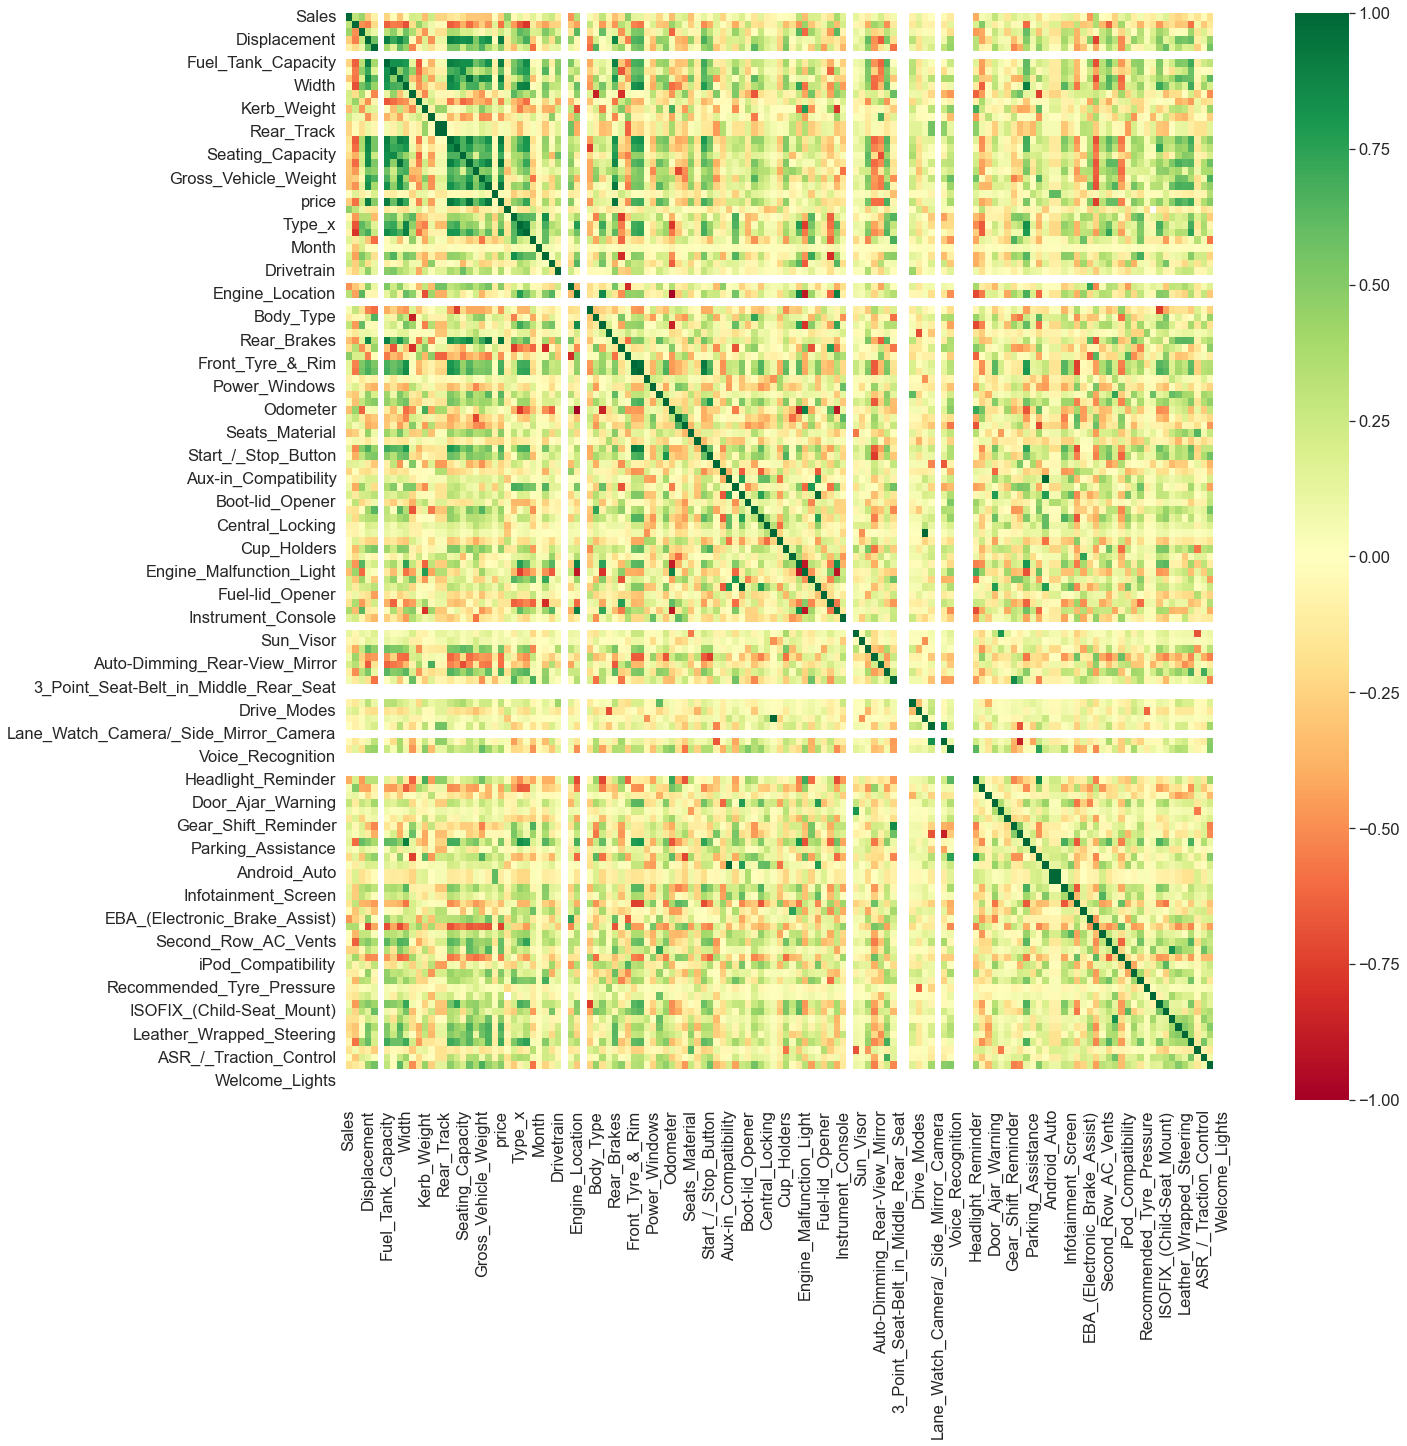

In [89]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (20, 20))
sns.heatmap(X_scaled_df.corr(), cmap="RdYlGn")
plt.show()

## Building a Linear Model

In [108]:
X_scaled_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4466 entries, 0 to 4465
Data columns (total 140 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    Sales                                      float64
 1    Monthly_Segment_Sales                      float64
 2    Percentage_Contribution                    float64
 3    Displacement                               float64
 4    Cylinders                                  float64
 5    Valves_Per_Cylinder                        float64
 6    Fuel_Tank_Capacity                         float64
 7    Height                                     float64
 8    Length                                     float64
 9    Width                                      float64
 10   Doors                                      float64
 11   ARAI_Certified_Mileage                     float64
 12   Kerb_Weight                                float64
 13   Ground_Clearance               

In [109]:
y_train = X_scaled_df.pop('Seating_Capacity')
X_train = X_scaled_df

In [110]:
X_train_1 = X_train['Make']

In [111]:
import statsmodels.api as sm
# Add a constant
X_train_1c = sm.add_constant(X_train_1)

# Create a first fitted model
lr_1 = sm.OLS(y_train, X_train_1c).fit()

In [112]:
lr_1.params

const    8.726066e-16
Make     3.857756e-01
dtype: float64

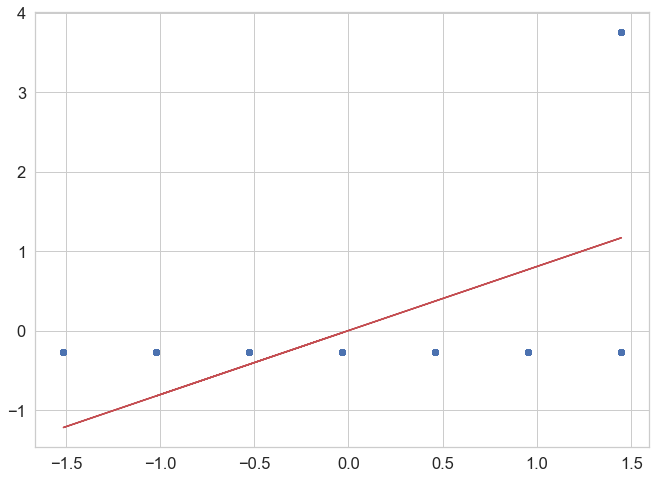

In [113]:
# Let's visualise the data with a scatter plot and the fitted regression line

plt.scatter(X_train_1c.iloc[:, 1], y_train)
plt.plot(X_train_1c.iloc[:, 1], 0.8062*X_train_1c.iloc[:, 1], 'r')
plt.show()

In [114]:
# Print a summary of the linear regression model obtained
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:       Seating_Capacity   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     780.5
Date:                Thu, 26 May 2022   Prob (F-statistic):          1.97e-158
Time:                        01:38:06   Log-Likelihood:                -5977.2
No. Observations:                4466   AIC:                         1.196e+04
Df Residuals:                    4464   BIC:                         1.197e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.726e-16      0.014   6.32e-14      1.0